In [1]:
from typing import Dict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pymc as pm
from pymc import model_to_networkx, model_to_graphviz
from pymc_experimental.model_builder import ModelBuilder

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class HierarchicalModel(ModelBuilder):

    _model_type = "HierarchicalModel"
    version = "0.01"
    def _data_setter(self, X, y=None):
        with self.model:
            pm.set_data({"x": X["x"].values})
            try:  # if y values in new data
                pm.set_data({"y": y.values})
            except:  # dummies otherwise
                pm.set_data({"y": np.zeros(len(X))})

    @property
    def output_var(self):
        return "target"

    @property
    def default_model_config(self) -> Dict:
        return {"mu_mu_a": 0, "sigma_mu_a": 10, "sigma_a": 10, "mu_mu_b": 0,"sigma_mu_b": 10, "sigma_b": 10, "sigma_sigma": 3}

    @property
    def default_sampler_config(self):
        return {
            'draws': 1_000,
            'tune': 1_000,
            'chains': 1,
            'cores': 1,
            'target_accept': 0.95,
        }
    
    def save_model_coords(self, X, y):
        groups = X['group'].unique().tolist()
        self.model_coords = {'groups':groups}


    def preprocess_model_data(self, X: DataFrame | Series, y: Series = None) -> None:
        X_prep = X.copy()
        X_prep['x'] = (X_prep['x'] - X_prep['x'].mean())/X_prep['x'].std()
        y_prep = y
        return X_prep, y_prep

    def build_model(self, X: DataFrame, y: Series, **kwargs) -> None:
        with pm.Model(coords = self.model_coords) as self.model:
            # Data
            X_ = pm.MutableData("x",X["x"].values)
            target_ = pm.MutableData('y',y)
            group_indices = np.array([self.model_coords['groups'].index(item) for item in X["group"]])

            # hyperparams
            mu_mu_a = self.model_config['mu_mu_a']
            sigma_mu_a = self.model_config['sigma_mu_a']
            sigma_a = self.model_config['sigma_a']

            mu_mu_b = self.model_config['mu_mu_b']
            sigma_mu_b = self.model_config['sigma_mu_b']
            sigma_b = self.model_config['sigma_b']
            sigma_sigma = self.model_config['sigma_sigma']

            # priors
            mu_a = pm.Normal('mu_a', mu_mu_a, sigma_mu_a)
            xi_a = pm.Normal('xi_a', 0,1,dims='groups')
            a = pm.Deterministic('a', mu_a + sigma_a*xi_a)

            mu_b = pm.Normal('mu_b', mu_mu_b, sigma_mu_b)
            xi_b = pm.Normal('xi_b', 0,1, dims = 'groups')
            b = pm.Deterministic('b', mu_b + xi_b  * sigma_b)

            sigma = pm.HalfNormal('sigma', sigma=sigma_sigma)

            # likelihood
            pm.Normal('target', mu=a[group_indices]+b[group_indices]*X_, sigma=sigma, observed = target_)
    
    @property
    def _serializable_model_config(self) -> Dict[str, int | float | Dict]:
        return self.model_config     

In [3]:
def generate_data(n_samples=100, n_groups=2, a = None, b = None):
    if (a is None ) and (b is None):
        a = np.random.randn(n_groups)
        b = np.random.randn(n_groups)
    groups = np.random.choice(n_groups, n_samples).astype(int)
    x = np.linspace(start=-5, stop=5, num=n_samples)
    y = a[groups] + b[groups] * x + np.random.randn(n_samples)
    X = pd.DataFrame({'x':x,'group':groups})
    y = pd.Series(y, name='y')
    return X, y, a, b

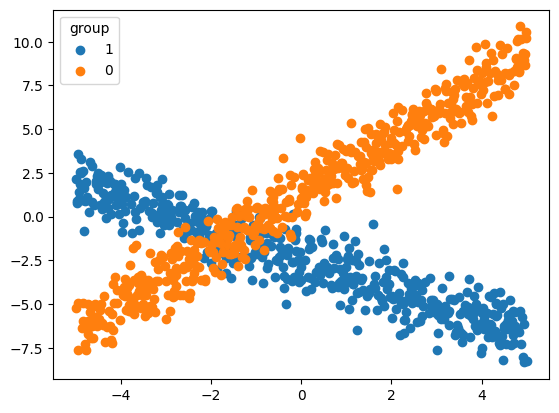

In [4]:
X, y, a ,b  = generate_data(1000, 2)
fig  = plt.figure()
for group in X['group'].unique():
    idx = X['group'] == group
    subset = X.loc[idx]
    plt.scatter(subset['x'], y[idx], label = group)
plt.legend(title='group')


In [5]:
model = HierarchicalModel()
idata = model.fit(X, y)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_a, xi_a, mu_b, xi_b, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 102 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [mu_a, mu_b, sigma, target, xi_a, xi_b]
Sampling: [target]


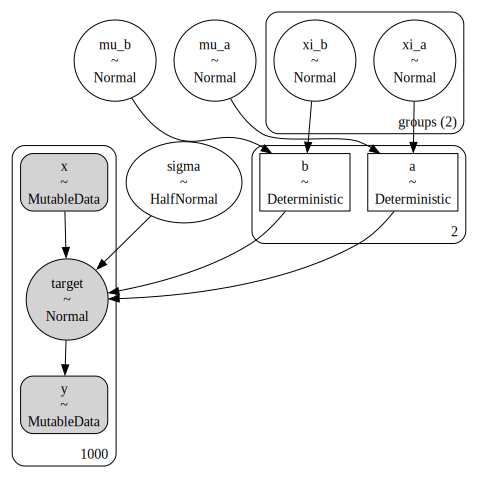

In [6]:
model_to_graphviz(model.model)

In [7]:
model.save('temp_model.nc')

In [8]:
new_X, new_y,_,_ = generate_data(a=a,b=b)
only_group = 1
idx = (new_X['group'] == only_group)
new_X = new_X.loc[idx]
new_y = new_y[idx]

In [9]:
loaded_model = HierarchicalModel.load('temp_model.nc')

In [10]:
y_pred = loaded_model.predict(new_X)

Sampling: [target]


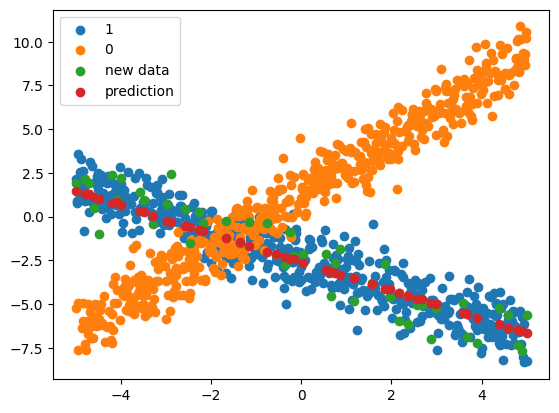

In [11]:
fig = plt.figure()
for group in X['group'].unique():
    idx = X['group'] == group
    subset = X.loc[idx]
    plt.scatter(subset['x'], y[idx], label = group)
plt.scatter(x=new_X['x'], y=new_y,  label='new data')
plt.scatter(x=new_X['x'], y=y_pred, label='prediction')
plt.legend()
plt.show()

Sampling: [target]


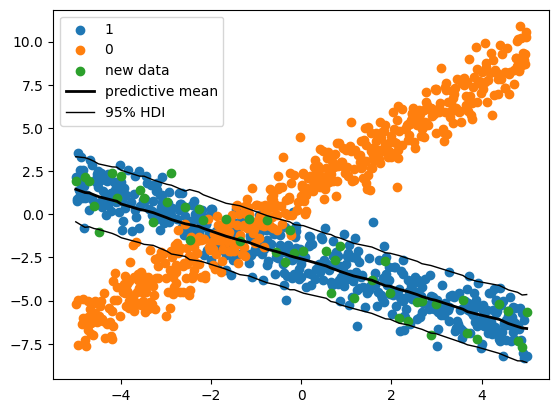

In [12]:
y_pred = loaded_model.predict_proba(new_X)

y_pred_mean = y_pred.mean(axis =(0,1))
y_pred_std = y_pred.std(axis = (0,1))


fig = plt.figure()
for group in X['group'].unique():
    idx = X['group'] == group
    subset = X.loc[idx]
    plt.scatter(subset['x'], y[idx], label = group)
plt.scatter(x=new_X['x'], y=new_y,  label='new data')
plt.plot(new_X['x'], y_pred_mean, label='predictive mean', color='black', linewidth=2)
plt.plot(new_X['x'], y_pred_mean+1.96*y_pred_std, label='95% HDI', color='black', linewidth=1)
plt.plot(new_X['x'], y_pred_mean-1.96*y_pred_std, color='black', linewidth=1)
plt.legend()
plt.show()